In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import t as student_t
from matplotlib.gridspec import GridSpec
import pandas as pd

In [5]:
# Code to load in the recoverability.csv file generated by the simulation
# Note: This code doesn't make use of the runtime information. That's handled
# by the second half of this analysis code.

def load_recoverability_tuples(path="recoverability.csv"):
    out = []
    with open(path, newline="") as f:
        r = csv.DictReader(f)
        for row in r:
            n = int(row["n"].strip())
            m = int(row["m"].strip())
            k = int(row["k"].strip())
            rec = float(row["recoverability"].strip())
            out.append((n, m, k, rec))
    return out

data = load_recoverability_tuples()

Slope (exponent wrt m): -0.520091
Intercept: 2.332129
95% CI for slope: [-0.533645, -0.506537]  (SE=0.006552, df=23, t*=2.069)


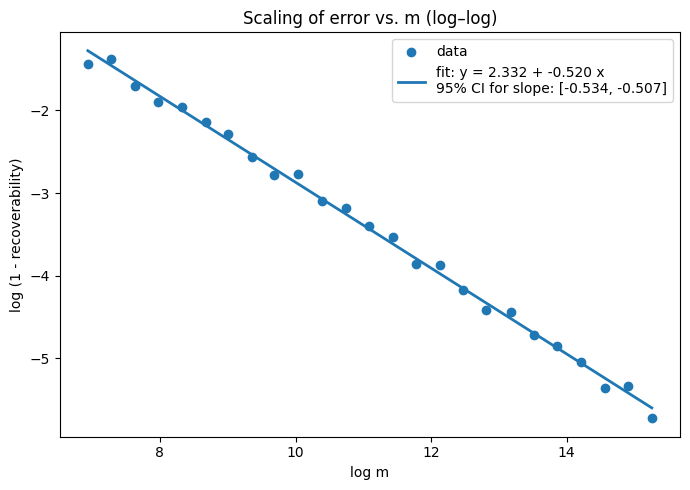

In [ ]:
# Simple visualization of the scaling of log(1 - expected recoverability) compared to log |S'|.
# Use this with the above function when you have a single recoverability experiment you'd like to analyze.

m = np.array([t[1] for t in data], dtype=float)
recov = np.array([t[3] for t in data], dtype=float)
err = 1.0 - recov
eps = 1e-15
err = np.clip(err, eps, 1.0)

# Getting log |S'| and log(1 - expected recoverability)
x = np.log(m)
y = np.log(err)

# Regress to get slope (the exponent p best satisfying 1 - E[R] ~ m^p)
b, a = np.polyfit(x, y, 1)

# Making the 95% CI for the slope
n = x.size
y_hat = a + b * x
res = y - y_hat
s2 = np.sum(res**2) / (n - 2)
Sxx = np.sum((x - x.mean())**2)
se_b = sqrt(s2 / Sxx)

t_crit = float(student_t.ppf(0.975, df=n-2))
b_lo = b - t_crit * se_b
b_hi = b + t_crit * se_b

print(f"Slope (exponent wrt m): {b:.6f}")
print(f"Intercept: {a:.6f}")
print(f"95% CI for slope: [{b_lo:.6f}, {b_hi:.6f}]  (SE={se_b:.6f}, df={n-2}, t*={t_crit:.3f})")

# Plot everything
x_line = np.linspace(x.min(), x.max(), 200)
y_line = a + b * x_line
plt.figure(figsize=(7, 5))
plt.scatter(x, y, label="data")
plt.plot(x_line, y_line, linewidth=2,
         label=f"fit: y = {a:.3f} + {b:.3f} x\n95% CI for slope: [{b_lo:.3f}, {b_hi:.3f}]")
plt.xlabel("log m")
plt.ylabel("log (1 - recoverability)")
plt.title("Scaling of error vs. m (log–log)")
plt.legend()
plt.tight_layout()
plt.show()


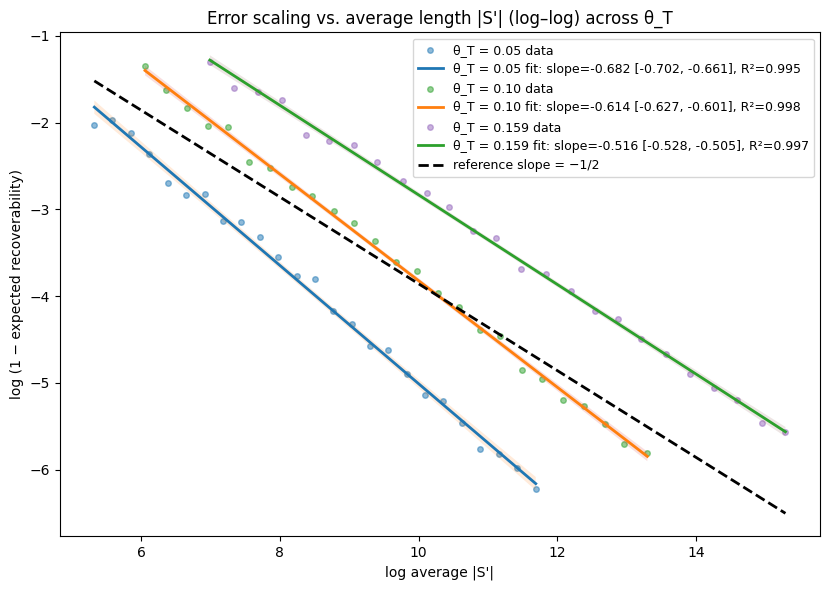


Summary (log–log regression: y = a + b x):
Label             Slope b               95% CI b    Intercept a      R^2      n
θ_T = 0.05      -0.681605 [-0.702344, -0.660866]       1.805557    0.995     25
θ_T = 0.10      -0.613906 [-0.626954, -0.600857]       2.316130    0.998     25
θ_T = 0.159     -0.516052 [-0.527597, -0.504508]       2.326618    0.997     25


In [6]:
# Graphs for recoverability scaling with m for varying values of theta_T.

datasets = {
    r"θ_T = 0.05":  "recoverability_theta_0.05.csv",
    r"θ_T = 0.10":  "recoverability_theta_0.10.csv",
    r"θ_T = 0.159": "recoverability_theta_0.159.csv",
}

def regress_loglog_error_vs_m(tuples):
    # Extract arrays and errors
    m = np.array([t[1] for t in tuples], dtype=float)
    recov = np.array([t[3] for t in tuples], dtype=float)
    eps = 1e-15
    err = np.clip(1.0 - recov, eps, 1.0)
    x = np.log(m)
    y = np.log(err)
    # Fit regression
    b, a = np.polyfit(x, y, 1)
    n = x.size
    y_hat = a + b * x
    res = y - y_hat
    s2 = np.sum(res**2) / (n - 2)
    Sxx = np.sum((x - x.mean())**2)
    se_b = sqrt(s2 / Sxx)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1.0 - np.sum(res**2) / ss_tot if ss_tot > 0 else float("nan")
    t_crit = float(student_t.ppf(0.975, df=n-2))
    b_lo, b_hi = b - t_crit * se_b, b + t_crit * se_b
    x_line = np.linspace(x.min(), x.max(), 200)
    y_line = a + b * x_line
    mean_se_line = np.sqrt(s2 * (1.0/n + (x_line - x.mean())**2 / Sxx))
    band_lo = y_line - t_crit * mean_se_line
    band_hi = y_line + t_crit * mean_se_line

    return {
        "x": x, "y": y,
        "a": a, "b": b, "b_lo": b_lo, "b_hi": b_hi, "se_b": se_b,
        "n": n, "r2": r2, "tcrit": t_crit,
        "x_line": x_line, "y_line": y_line,
        "band_lo": band_lo, "band_hi": band_hi,
    }

# This assumes that the files in the path are 'recoverability_theta_0.05.csv',
# 'recoverability_theta_0.10.csv', and 'recoverability_theta_0.159.csv'
results = {}
for label, path in datasets.items():
    tuples = load_recoverability_tuples(path)
    results[label] = regress_loglog_error_vs_m(tuples)

x_all = np.concatenate([res["x"] for res in results.values()])
y_all = np.concatenate([res["y"] for res in results.values()])
x_min, x_max = x_all.min(), x_all.max()
x_ref = np.linspace(x_min, x_max, 200)

# Reference slope −1/2 line
b_ref = -0.5
a_ref = np.median(y_all) - b_ref * np.median(x_all)
y_ref = a_ref + b_ref * x_ref

plt.figure(figsize=(8.4, 6.0))

for label, res in results.items():
    plt.scatter(res["x"], res["y"], s=16, alpha=0.5, label=f"{label} data")
    plt.plot(res["x_line"], res["y_line"], linewidth=2,
             label=(f"{label} fit: slope={res['b']:.3f} "
                    f"[{res['b_lo']:.3f}, {res['b_hi']:.3f}], "
                    f"R²={res['r2']:.3f}"))
    # 95% CI band
    plt.fill_between(res["x_line"], res["band_lo"], res["band_hi"], alpha=0.15, linewidth=0)

plt.plot(x_ref, y_ref, linestyle="--", linewidth=2, color="k",
         label="reference slope = −1/2")

plt.xlabel("log average |S'|")
plt.ylabel("log (1 − expected recoverability)")
plt.title("Error scaling vs. average length |S'| (log–log) across θ_T")
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.show()

# summary table
print("\nSummary (log–log regression: y = a + b x):")
print(f"{'Label':<14} {'Slope b':>10} {'95% CI b':>22} {'Intercept a':>14} {'R^2':>8} {'n':>6}")
for label, res in results.items():
    print(f"{label:<14} {res['b']:>10.6f} "
          f"[{res['b_lo']:.6f}, {res['b_hi']:.6f}] "
          f"{res['a']:>14.6f} {res['r2']:>8.3f} {res['n']:>6d}")


/tmp/ipython-input-3413121106.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


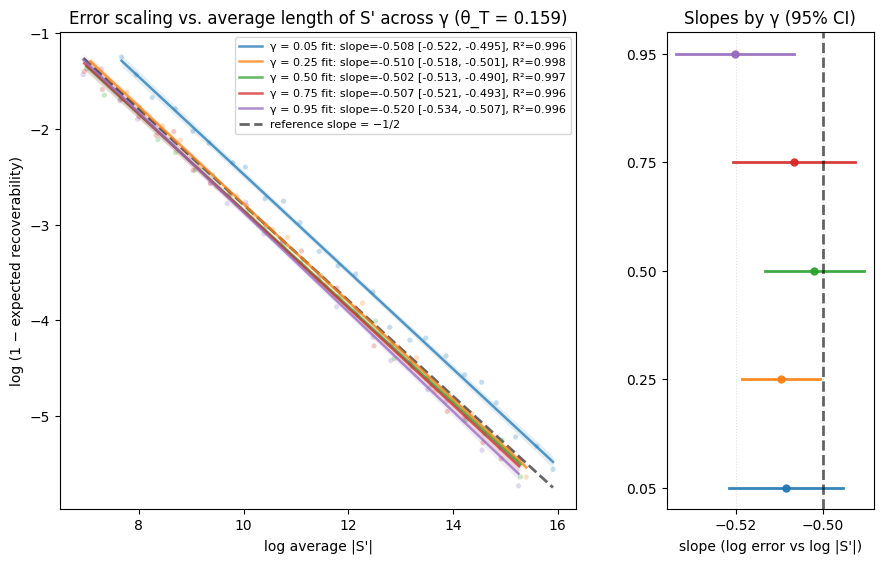

In [ ]:
# Graphs for recoverability scaling with m for varying values of gamma
SCATTER_ALPHA = 0.25
SCATTER_SIZE  = 14
LINE_ALPHA    = 0.75
LINE_WIDTH    = 1.8
BAND_ALPHA    = 0.12
REF_ALPHA     = 0.6
REF_WIDTH     = 2.0
fig = plt.figure(figsize=(10.5, 6.2))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[3.0, 1.2], wspace=0.25)

ax = fig.add_subplot(gs[0, 0])
colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', None)
labels_sorted = sorted(results.keys(), key=lambda s: float(s.split('=')[1]))
for idx, label in enumerate(labels_sorted):
    res = results[label]
    color = colors[idx % len(colors)] if colors else None
    ax.scatter(
        res["x"], res["y"],
        s=SCATTER_SIZE, alpha=SCATTER_ALPHA, color=color,
        edgecolors='none', linewidths=0, zorder=2, label=f"{label} data"
    )
    ax.plot(
        res["x_line"], res["y_line"],
        linewidth=LINE_WIDTH, alpha=LINE_ALPHA, color=color, zorder=3,
        label=(f"{label} fit: slope={res['b']:.3f} "
               f"[{res['b_lo']:.3f}, {res['b_hi']:.3f}], R²={res['r2']:.3f}")
    )
    ax.fill_between(
        res["x_line"], res["band_lo"], res["band_hi"],
        alpha=BAND_ALPHA, color=color, linewidth=0, zorder=1
    )

# reference −1/2 slope
ax.plot(
    x_ref, y_ref, linestyle="--", linewidth=REF_WIDTH, color="k",
    alpha=REF_ALPHA, zorder=1.5, label="reference slope = −1/2"
)

ax.set_xlabel("log average |S'|")
ax.set_ylabel("log (1 − expected recoverability)")
ax.set_title("Error scaling vs. average length of S' across γ (θ_T = 0.159)")
handles, labels = ax.get_legend_handles_labels()
ordered = []
seen = set()
for h, l in zip(handles, labels):
    if "fit:" in l and l not in seen:
        ordered.append((h, l)); seen.add(l)
ordered.append((handles[-1], labels[-1]))
ax.legend([h for h, _ in ordered], [l for _, l in ordered], loc="best", fontsize=8)

# Forest panel
ax2 = fig.add_subplot(gs[0, 1])
def parse_gamma(label):
    return float(label.split("=")[1].strip())

items = sorted(results.items(), key=lambda kv: parse_gamma(kv[0]))
gammas = np.array([parse_gamma(lbl) for lbl, _ in items], dtype=float)
slopes = np.array([res["b"] for _, res in items], dtype=float)
ci_lo  = np.array([res["b_lo"] for _, res in items], dtype=float)
ci_hi  = np.array([res["b_hi"] for _, res in items], dtype=float)

y_pos = np.arange(len(gammas))
for i, color in zip(range(len(gammas)), colors):
    ax2.plot([ci_lo[i], ci_hi[i]], [y_pos[i], y_pos[i]],
             linewidth=2, color=color, alpha=0.9)
    ax2.plot(slopes[i], y_pos[i], marker="o", color=color, alpha=0.9, markersize=5)

ax2.axvline(-0.5, linestyle="--", linewidth=REF_WIDTH, color="k", alpha=REF_ALPHA)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([f"{g:.2f}" for g in gammas])
ax2.set_xlabel("slope (log error vs log |S'|)")
ax2.set_title("Slopes by γ (95% CI)")
ax2.grid(axis="x", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()


The code below is for analyzing the empirical and predicted runtimes of seed chain extend under the indel model detailed in the paper.

In [4]:
# We used the following values of alpha and gamma in the runtime experiments
alpha = -np.log(1 - 0.10) / np.log(4)
C = (3 / (1 - 2 * alpha))

In [5]:
print(C, alpha)

3.5377487545181285 0.07600154672252499


In [6]:
3*2*alpha / (1 - 2*alpha) # The value of 2*C*alpha

np.float64(0.5377487545181282)

In [7]:
def _prepare_runtime_data(C, alpha, filename="runtime_info.csv"):
    """
    This function takes as input the file generated by the main script.
    """
    df = pd.read_csv(filename)

    # use k > 25. Too small values of k (n) are not representative of asymptotics
    df = df[df["k"] > 25].reset_index(drop=True)
    if len(df) < 2:
        raise ValueError("Not enough rows with k > 30 to compare growth.")

    n = df["n"].astype(float).values
    m = df["m"].astype(float).values
    f = df["expected_runtime"].astype(float).values

    # get theoretical predictions for expected runtime
    g = m * (n ** (C * alpha)) * np.log(n)

    ratio = f / g
    return n, f, g, ratio


def plot_runtime_vs_theory(C, alpha, filename="runtime_info.csv"):
    n, f, g, _ = _prepare_runtime_data(C, alpha, filename)

    # Scale g so first point matches
    scale = f[0] / g[0]
    print(f'scale={scale}')
    g_scaled = g * 2 * scale

    plt.figure(figsize=(8, 6))
    plt.ticklabel_format(style='plain', axis='y')
    plt.plot(n, f, marker="o", label="f(n) = real total runtime")
    plt.plot(n, g_scaled, marker="s", linestyle="--",
            label="h(n) = scaled m n^(Cα) log n")
    plt.xlabel("n = |S|")
    plt.ylabel("Extension runtime")
    plt.title("Growth comparison: f(n) vs scaled h(n)")
    plt.grid(True)
    plt.legend()
    plt.show()



def plot_runtime_ratio(C, alpha, filename="runtime_info.csv"):
    n, f, g, ratio = _prepare_runtime_data(C, alpha, filename)

    plt.figure(figsize=(8, 6))
    plt.plot(n, ratio, marker="o")
    plt.xlabel("n = |S|")
    plt.ylabel("f(n) / h(n)")
    plt.title("Ratio f(n) / h(n)")
    plt.grid(True)
    plt.show()

    print("Min f/g:", np.min(ratio))
    print("Max f/g:", np.max(ratio))
    print("If f = O(g), this ratio should stay bounded (not blow up with n).")

scale=3.873799101309475e-08


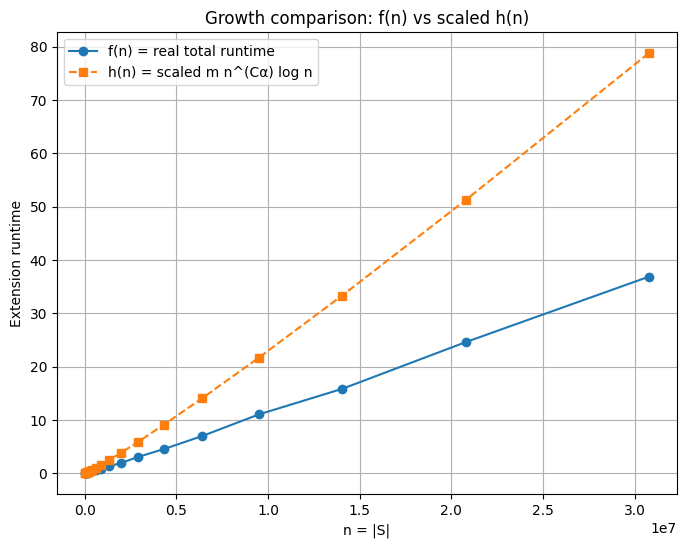

In [8]:
plot_runtime_vs_theory(C, alpha)


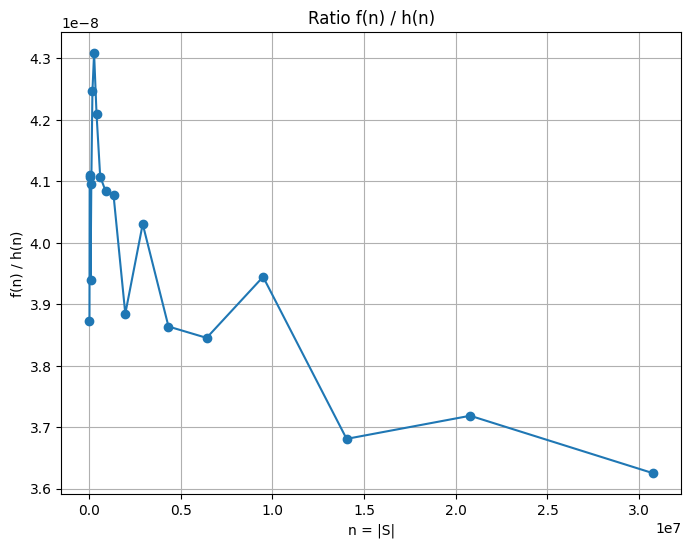

Min f/g: 3.625456433017963e-08
Max f/g: 4.308512604357309e-08
If f = O(g), this ratio should stay bounded (not blow up with n).


In [9]:
plot_runtime_ratio(C, alpha)